In [ ]:
# pip install graphviz

In [ ]:
pip install daylight

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for daylight: filename=daylight-0.1.3-cp310-cp310-linux_x86_64.whl size=68801 sha256=2d1bdfff7e4678fb1a2077246d29f02cee8b1d3b01aa2ca7db74384d1a8f432c
  Stored in directory: /root/.cache/pip/wheels/e6/23/b0/d7614812851c8a8af2d134415a7e89d1b1881df375c9102a85
Successfully built daylight
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import datetime
import pytz

from statistics import mean, median, variance, stdev

import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.gofplots import qqplot
import scipy as sp

#import graphviz as gr
import matplotlib.pyplot as plt
import seaborn as sn

import daylight

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# SparkSession
spark = SparkSession.builder.getOrCreate()

### Functions

In [ ]:
def handling_missing(data: pd.DataFrame,
                     location_id: str,
                     date: str,
                     intervention_date: str,
                     energy: str,
                     threshold_missing_timestamp: int,
                     threshold_zero_values: int) -> pd.DataFrame:
    """
    Main focus: Handling missing timestamps
    Approach: Applying various conditions to filter out locations based on a threshold for missing timestamps.
    """

    # Create an empty DataFrame to store all missing rows for all location_id
    result_df = pd.DataFrame()

    # Iterate over each unique location_id values
    for loc_id, group in data.groupby(location_id):

        # Condition: Check if the group is not empty and intervention_date column has non-missing values, otherwise drop the group
        if not group.empty and not group[intervention_date].isna().all():

            # Get first and last date
            startDate, endDate = group[date].min(), group[date].max()

            # Get total number of days within first and last date for location_id
            tot_days = round((endDate - startDate) / np.timedelta64(1, 'D'))

            # Get intervention timestamp
            intervention = group[intervention_date].iloc[0]

            # Condition: Check if tot_days is not zero
            if tot_days != 0:

                # Get missing timestamps within each group and its count
                missing_timestamps = pd.date_range(start=startDate, end=endDate).difference(group[date])
                number_missing_timestamps = len(missing_timestamps)

                # Get proportion of missing timestamps within the range
                proportion_missing_timespamp = (number_missing_timestamps / tot_days) * 100

                # Get proportion of zero-values with the range
                proportion_zero_values = ((group[energy]==0).sum() / tot_days) * 100

                # Condition: If no missing values, just go ahead with the next group
                if number_missing_timestamps != 0:

                    # Condition: Check whether proportion of zero values is within the threshold, otherwise drop the group
                    if proportion_zero_values <= threshold_zero_values:

                        # Condition: Check whether proportion of missing timestamp is within the threshold, otherwise drop the group
                        if proportion_missing_timespamp <= threshold_missing_timestamp:

                            # Define DataFrame with missing values
                            missing_data = pd.DataFrame({
                                location_id: loc_id,
                                date: missing_timestamps,
                                intervention_date: intervention,
                                energy: group[energy].mean()})

                            # Append missing_data to the result DataFrame
                            result_df = pd.concat([result_df, missing_data], ignore_index=True)

                        else:
                            data.drop(group.index, inplace=True) #.reset_index(drop=True)
                    else:
                        data.drop(group.index, inplace=True)
            else:
                data.drop(group.index, inplace=True) #.reset_index(drop=True)
        else:
            data.drop(group.index, inplace=True) #.reset_index(drop=True)

    # Concatenate the original DataFrame and the result DataFrame, sort by location_id and date
    return pd.concat([data, result_df]).sort_values([location_id, date]).reset_index(drop=True)

In [ ]:
def filtering_extracting(data: pd.DataFrame,
                         location_id: str,
                         date:str,
                         intervention_date: str,
                         months: int) -> pd.DataFrame:
    """
    Main focus: Filtering and extracting relevant energy values.
    Approach: Applying various conditions to filter out locations based on a specific time period in months.
    """
    # Iterate over each unique location_id values
    for _, group in data.groupby(location_id):

        # Get intervention timestamps
        intervention = group[intervention_date].iloc[0]

        # Get first and last date
        startDate, endDate = group[date].min(), group[date].max()

        # Get data for before/after intervention given n months
        before, after = intervention - pd.DateOffset(months=months), intervention + pd.DateOffset(months=months)

        # Check if before/after intervention are in the range of existing values, otherwise drop the group
        if before >= startDate and after <= endDate:

            # Get indexes for those rows out of the range before-after
            indexes_to_drop = group[ (group[date] < before) | (group[date] > after) ].index

            # Drop only those rows out of range before-after
            data.drop(indexes_to_drop, inplace=True)
        else:
            data.drop(group.index, inplace=True) #.reset_index(drop=True)

    # Sort by location_id and date
    return data.sort_values([location_id, date]).reset_index(drop=True)

In [ ]:
def epoch(year: int,
          month: int,
          day: int,
          hour: int = 0,
          minute: int = 0,
          second: int = 0,
          tz = pytz.UTC) -> int:
    '''
    Main focus: Converting date and time to epoch timestamp
    Approach: Localizing the datetime object to the specified timezone and extracting the corresponding epoch timestamp
    '''
    return int(tz.localize(datetime.datetime(year, month, day, hour, minute, second)).timestamp())

In [ ]:
def brightness(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Main focus: Compute brightness metrics (avg, max, sunrise-to-sunset) for each location and date
    Approach: Utilize an inner function (calculate_brightness) to compute brightness for each location_id, then join the original DataFrame with the resulting brightness DataFrame (result_df)
    '''
    # Create an empty DataFrame to store all brigthness values for all location_id
    result_df = pd.DataFrame()

    # Define inner function to calculate the brightness values (avg brightness, max brightness, sunrise to sunset brightness)
    def calculate_brightness(single_date: str,
                             location_id: str) -> pd.Series:
        # Get year, month and day
        year, month, day = single_date.year, single_date.month, single_date.day

        # Get sunrise and sunset in datetime format
        sunrise, sunset = datetime.datetime.fromtimestamp(sunclock.sunrise(epoch(year, month, day, tz=tz)), tz), datetime.datetime.fromtimestamp(sunclock.sunset(epoch(year, month, day, tz=tz)), tz)

        # Convert sunrise and sunset time into total minutes since midnight
        sunrise_min, sunset_min = sunrise.hour * 60 + sunrise.minute, sunset.hour * 60 + sunset.minute

        # Create a DataFrame with 24 hours expressed in minutes since midnight
        temp_df = pd.DataFrame([ h*60+m for h,m in zip(range(24), range(60)) ], columns=['time_of_day']) #.set_index('time_of_day')

        # Add brightness_hours column: compute the brightness for each hours of the day
        temp_df['brightness_hours'] = temp_df['time_of_day'].apply( lambda t, y=year, m=month, d=day, tz=tz, latitude=latitude, longitude=longitude, sunclock=sunclock:((sunclock.irradiance(epoch(y, m, d, t//60, t%60, tz=tz)) +1 ) /2) ** math.e)

        # Get avg brightness (of the day), max brightness (of the day) and sunrise to sunset brightness (of the day)
        brightness = round(temp_df['brightness_hours'].mean(), 2)
        brightnessmax = round(temp_df['brightness_hours'].max(), 2)
        brightness_s2s = round(pd.Series(np.arange(sunrise_min, sunset_min+1)).apply(lambda t, y=year, m=month, d=day, tz=tz, latitude=latitude, longitude=longitude, sunclock=sunclock: ((sunclock.irradiance(epoch(y, m, d, t//60, t%60, tz=tz)) +1 ) /2) ** math.e).mean(), 2)

        # Return these values in pandas Series
        return pd.Series( {'location_id':location_id, 'date':single_date, 'brightness':brightness, 'brightnessmax':brightnessmax, 'brightness_s2s':brightness_s2s} )

    # Iterate over each unique location_id values
    for location_id, group in df.groupby('location_id'):

        # Create timezone oblject (tz) that represents the timezone of a city/region
        tz = pytz.timezone(group['timezone'].iloc[0])

        # Get longitude and latitude
        longitude, latitude = group['longitude'].iloc[0], group['latitude'].iloc[0]

        # Create a Sunclock object
        sunclock = daylight.Sunclock(latitude, longitude)

        # Concatenate brightness values for current location with result_df
        result_df = pd.concat([result_df, group['date'].apply(lambda date: calculate_brightness(date, location_id))])

    # Return a joined version of original df with result_df --> For each location_id and date, we computed brightness, brightnessmax and brightness_s2s
    return pd.merge(df, result_df, on=['location_id', 'date'], how='left')

In [ ]:
def price_cleaning(df: pd.DataFrame,
                   price: str,
                   *args) -> pd.DataFrame:
    """
    Main focus: Filling missing values in specified columns
    Approach: Group the DataFrame by 'location_id' and fill missing values in the 'price' column using forward fill ('ffill') and backward fill ('bfill'). Fill missing values in other specified columns (from *args) with zero
    """

    # Inner function
    def filling(group: pd.DataFrame) -> pd.DataFrame:

        # Fill nan in price column with last and next valid observation
        group[price].fillna(method='ffill', inplace=True)
        group[price].fillna(method='bfill', inplace=True)

        # Fill nan in other specified columns with zero
        for arg in args:
            group[arg] = group[arg].fillna(value=0)
        return group

    # Return DataFrame with filled missing values
    return df.groupby('location_id').apply(filling).reset_index(drop=True)

### Preprocessing data

#### Step 1 - energy consumption cleaning

In [ ]:
# Load data
table_name = 'eliqdatalake.playground.jersey_treated_only'
query = f"SELECT * FROM {table_name}"
df = spark.sql(query).toPandas()

In [ ]:
# Check shape of dataset
df.shape

(11566655, 5)

In [ ]:
# Convert 'terms_accepted_datetime' to midnight
df['terms_accepted_datetime'] = df['terms_accepted_datetime'].dt.normalize()

In [ ]:
# Drop device_id column
df.drop('device_id', inplace=True, axis=1)

In [ ]:
# Check dataset
df.head()

,location_id,curr_date,terms_accepted_datetime,energy
0,1420035,2020-08-13,2021-03-31,20496
1,1420035,2020-08-14,2021-03-31,18913
2,1420035,2020-08-15,2021-03-31,20997
3,1420035,2020-08-16,2021-03-31,21529
4,1420035,2020-08-17,2021-03-31,21889


In [ ]:
# Check missing values
df.isna().sum()

location_id                0
curr_date                  0
terms_accepted_datetime    0
energy                     0
dtype: int64

In [ ]:
# Count unique values for each column
df.nunique()

location_id                  9606
curr_date                    1783
terms_accepted_datetime       857
energy                     136783
dtype: int64

In [ ]:
# For each location_id, check duplicates within 'curr_date' --> Already checked in Databricks
duplicates_curr_date = set(df
                           .groupby('location_id')['curr_date']
                           .apply(lambda x: x.duplicated().sum()))
duplicates_curr_date

{0}

In [ ]:
# For each location_id, check unique values within 'terms_accepted_datetime' -> Already checked in Databricks
unique_tad = set(df
                .groupby('location_id')['terms_accepted_datetime']
                .apply(lambda x: len(x.unique()) == 1))
unique_tad

{True}

In [ ]:
# For each location_id, get number of missing time_stamps in 'curr_date'
result = (df
        .groupby('location_id')['curr_date']
        .apply(lambda x: len(pd.date_range(start=x.min(), end=x.max()).difference(x))))
result

location_id
1420035    12
1420037     7
1420043     9
1420059    27
1420066     7
           ..
6497336     0
6497337     0
6504596     0
6504616     0
6506097     0
Name: curr_date, Length: 9606, dtype: int64

In [ ]:
# 4 min -> 64064 new rows
df_semi_cleaned = handling_missing(data=df,
                                   location_id='location_id',
                                   date='curr_date',
                                   intervention_date='terms_accepted_datetime',
                                   energy='energy',
                                   threshold_missing_timestamp=20,
                                   threshold_zero_values=10)
df_semi_cleaned

,location_id,curr_date,terms_accepted_datetime,energy
0,1420035,2020-08-13,2021-03-31,20496.0
1,1420035,2020-08-14,2021-03-31,18913.0
2,1420035,2020-08-15,2021-03-31,20997.0
3,1420035,2020-08-16,2021-03-31,21529.0
4,1420035,2020-08-17,2021-03-31,21889.0
...,...,...,...,...
11630714,6497336,2023-11-16,2021-05-22,17219.0
11630715,6497336,2023-11-17,2021-05-22,18650.0
11630716,6497337,2023-11-16,2021-06-22,7380.0
11630717,6497337,2023-11-17,2021-06-22,18870.0


In [ ]:
# total of 3.77 hours (avg 14min every 500 location_id)
df_cleaned = filtering_extracting(df_semi_cleaned, 'location_id', 'curr_date', 'terms_accepted_datetime', months=12)

In [ ]:
df_cleaned.nunique()

location_id                  5042
curr_date                    1341
terms_accepted_datetime       526
energy                     116578
dtype: int64

In [ ]:
# Get number of missing time_stamps in 'curr_date' for each location_id --> No missing timestamps
result = (df_cleaned
        .groupby('location_id')['curr_date']
        .apply(lambda x: len(pd.date_range(start=x.min(), end=x.max()).difference(x)) == 0).all())
result

True

In [ ]:
df_cleaned['location_id'].unique()[:10]

array([1420037, 1420043, 1420059, 1420066, 1420072, 1420073, 1420076,
       1420086, 1420088, 1420089])

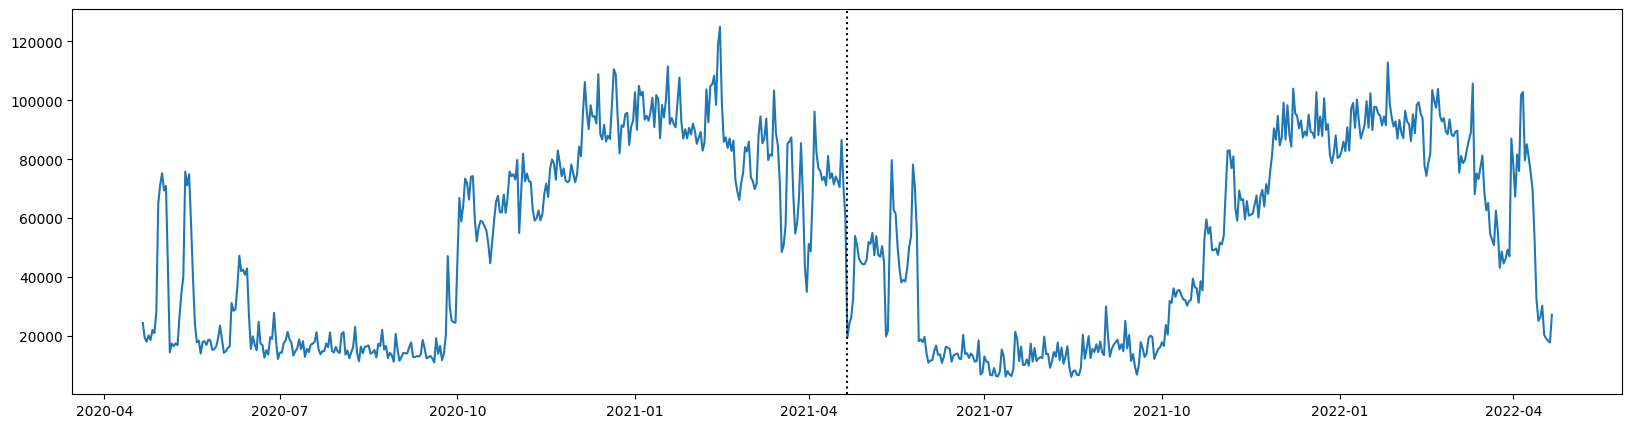

In [ ]:
energy_data = df_cleaned[df_cleaned['location_id'] == 1420076][['curr_date','terms_accepted_datetime', 'energy']]

fig = plt.subplots(figsize=(20,5))
plt.plot(energy_data['curr_date'], energy_data['energy'])
plt.axvline(energy_data['terms_accepted_datetime'].iloc[0], c='k', ls=':')

In [ ]:
# Convert pandas.DataFrame to PySpark DataFrame
df_cleaned_spark = spark.createDataFrame(df_cleaned)

In [ ]:
# Overview of df_cleaned_spark
df_cleaned_spark.show()
df_cleaned_spark.printSchema()

+-----------+-------------------+-----------------------+-------+
|location_id|          curr_date|terms_accepted_datetime| energy|
+-----------+-------------------+-----------------------+-------+
|    1420037|2020-09-20 00:00:00|    2021-09-20 00:00:00| 9429.0|
|    1420037|2020-09-21 00:00:00|    2021-09-20 00:00:00|10173.0|
|    1420037|2020-09-22 00:00:00|    2021-09-20 00:00:00| 7932.0|
|    1420037|2020-09-23 00:00:00|    2021-09-20 00:00:00| 7901.0|
|    1420037|2020-09-24 00:00:00|    2021-09-20 00:00:00| 8638.0|
|    1420037|2020-09-25 00:00:00|    2021-09-20 00:00:00| 9909.0|
|    1420037|2020-09-26 00:00:00|    2021-09-20 00:00:00|11086.0|
|    1420037|2020-09-27 00:00:00|    2021-09-20 00:00:00| 9062.0|
|    1420037|2020-09-28 00:00:00|    2021-09-20 00:00:00| 7824.0|
|    1420037|2020-09-29 00:00:00|    2021-09-20 00:00:00| 7997.0|
|    1420037|2020-09-30 00:00:00|    2021-09-20 00:00:00| 8828.0|
|    1420037|2020-10-01 00:00:00|    2021-09-20 00:00:00| 8692.0|
|    14200

In [ ]:
# Save df_cleaned as jersey_treated_only_cleaned table in eliqdatalake.playground
df_cleaned_spark.write.saveAsTable("eliqdatalake.playground.jersey_treated_only_cleaned", mode="overwrite")

#### Step 2 - weather cleaning

In [ ]:
# Load jersey treated only cleaned
table_name_energy = 'eliqdatalake.playground.jersey_treated_only_cleaned'
query_energy = f"SELECT * FROM {table_name_energy}"
energy = spark.sql(query_energy).toPandas().sort_values(['location_id', 'curr_date']).reset_index(drop=True)

In [ ]:
# Load jersey weather data
table_name_weather = 'eliqdatalake.playground.jersey_weather_data'
query_weather = f"SELECT * FROM {table_name_weather}"

temp_PySpark_df = spark.sql(query_weather)

temp_PySpark_df = temp_PySpark_df.withColumn("temp", col("temp").cast("double"))
temp_PySpark_df = temp_PySpark_df.withColumn("tempmin", col("tempmin").cast("double"))
temp_PySpark_df = temp_PySpark_df.withColumn("tempmax", col("tempmax").cast("double"))
temp_PySpark_df = temp_PySpark_df.withColumn("preciptot", col("preciptot").cast("double"))
temp_PySpark_df = temp_PySpark_df.withColumn("precip", col("precip").cast("double"))
temp_PySpark_df = temp_PySpark_df.withColumn("sealevelpressure", col("sealevelpressure").cast("double"))
temp_PySpark_df = temp_PySpark_df.withColumn("windspeed", col("windspeed").cast("double"))

weather = temp_PySpark_df.toPandas().sort_values(['location_id', 'date']).reset_index(drop=True)

In [ ]:
# Rename columns: curr_date --> date, terms_accepted_datetime --> intervention
energy.rename(columns={'curr_date':'date', 'terms_accepted_datetime':'intervention'}, inplace=True)
energy

,location_id,date,intervention,energy
0,1420037,2020-09-20,2021-09-20,9429.0
1,1420037,2020-09-21,2021-09-20,10173.0
2,1420037,2020-09-22,2021-09-20,7932.0
3,1420037,2020-09-23,2021-09-20,7901.0
4,1420037,2020-09-24,2021-09-20,8638.0
...,...,...,...,...
3685697,6454244,2022-06-10,2021-06-14,5929.0
3685698,6454244,2022-06-11,2021-06-14,5993.0
3685699,6454244,2022-06-12,2021-06-14,5704.0
3685700,6454244,2022-06-13,2021-06-14,6135.0


In [ ]:
# Convert column date from datetime.date to pandas._libs.tslibs.timestamps.Timestamp
weather['date'] = weather['date'].apply(pd.Timestamp)
weather

,location_id,date,temp,tempmin,tempmax,cloudcover,humidity,preciptot,precip,sealevelpressure,solarenergytot,solarenergy,solarradiation,windspeed
0,1420035,2020-03-01,7.4,5.1,10.0,43.0,80.0,6.0,0.3,993.2,NaN,NaN,NaN,27.7
1,1420035,2020-03-02,7.2,5.0,9.0,39.0,79.0,8.6,0.4,991.2,NaN,NaN,NaN,24.8
2,1420035,2020-03-03,7.2,5.0,9.0,33.0,77.0,2.5,0.1,NaN,NaN,NaN,NaN,19.6
3,1420035,2020-03-04,8.1,6.0,10.1,51.0,93.0,3.6,0.2,NaN,NaN,NaN,NaN,20.7
4,1420035,2020-03-05,8.2,6.0,11.0,64.0,90.0,23.2,1.0,992.0,1700.0,567.0,165.0,24.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17049160,6809215,2023-11-28,9.2,7.0,9.7,62.0,77.0,0.7,0.0,NaN,4400.0,183.0,50.0,13.2
17049161,6809215,2023-11-29,9.3,8.7,9.8,80.0,78.0,2.1,0.1,NaN,3100.0,129.0,36.0,9.5
17049162,6809215,2023-11-30,7.3,6.4,8.5,95.0,81.0,1.3,0.1,997.1,1600.0,67.0,18.0,17.5
17049163,6809215,2023-12-01,7.0,6.3,7.6,57.0,70.0,3.8,0.2,999.3,2600.0,108.0,32.0,25.3


In [ ]:
# Join energy and weather data
data = energy.merge(weather, how='left', on=['location_id', 'date'])
data

,location_id,date,intervention,energy,temp,tempmin,tempmax,cloudcover,humidity,preciptot,precip,sealevelpressure,solarenergytot,solarenergy,solarradiation,windspeed
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,22.0,17.0,86.0,0.0,0.0,NaN,NaN,NaN,NaN,12.2
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,16.0,23.0,11.0,84.0,0.0,0.0,NaN,NaN,NaN,NaN,12.5
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,16.0,20.0,42.0,93.0,0.2,0.0,NaN,NaN,NaN,NaN,13.5
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,13.0,17.0,38.0,84.0,1.8,0.1,NaN,NaN,NaN,NaN,28.0
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,10.0,15.0,36.0,77.0,4.4,0.2,996.7,NaN,NaN,NaN,40.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685697,6454244,2022-06-10,2021-06-14,5929.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3685698,6454244,2022-06-11,2021-06-14,5993.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3685699,6454244,2022-06-12,2021-06-14,5704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3685700,6454244,2022-06-13,2021-06-14,6135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check missing values for each columns
data.isna().sum()

location_id               0
date                      0
intervention              0
energy                    0
temp                   6579
tempmin                6579
tempmax                6579
cloudcover            27050
humidity               6579
preciptot              6579
precip                 6579
sealevelpressure    3320581
solarenergytot      2991254
solarenergy         2991254
solarradiation      2991254
windspeed              6579
dtype: int64

In [ ]:
# Drop sealevelpressure, solarenergytot, solarenergy and solarradiation
data.drop(['sealevelpressure','solarenergytot', 'solarenergy', 'solarradiation'], axis=1, inplace=True)

In [ ]:
data['location_id'].unique()[:20]

array([1420037, 1420043, 1420059, 1420066, 1420072, 1420073, 1420076,
       1420086, 1420088, 1420089, 1420090, 1420092, 1420099, 1420102,
       1420107, 1420114, 1420117, 1420118, 1420120, 1420122])

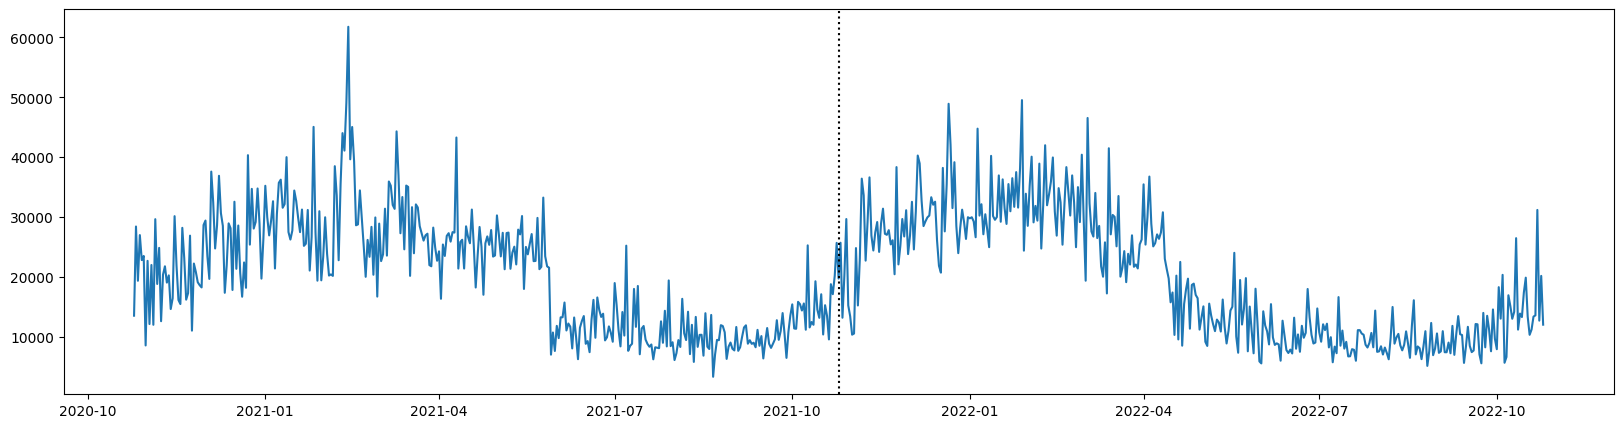

In [ ]:
energy_data = data[data['location_id'] == 6377801][['date','intervention', 'energy', 'temp', 'tempmin', 'tempmax', 'cloudcover', 'humidity', 'preciptot', 'precip', 'windspeed']]

fig = plt.subplots(figsize=(20,5))
plt.plot(energy_data['date'], energy_data['energy'])
plt.axvline(energy_data['intervention'].iloc[0], c='k', ls=':')

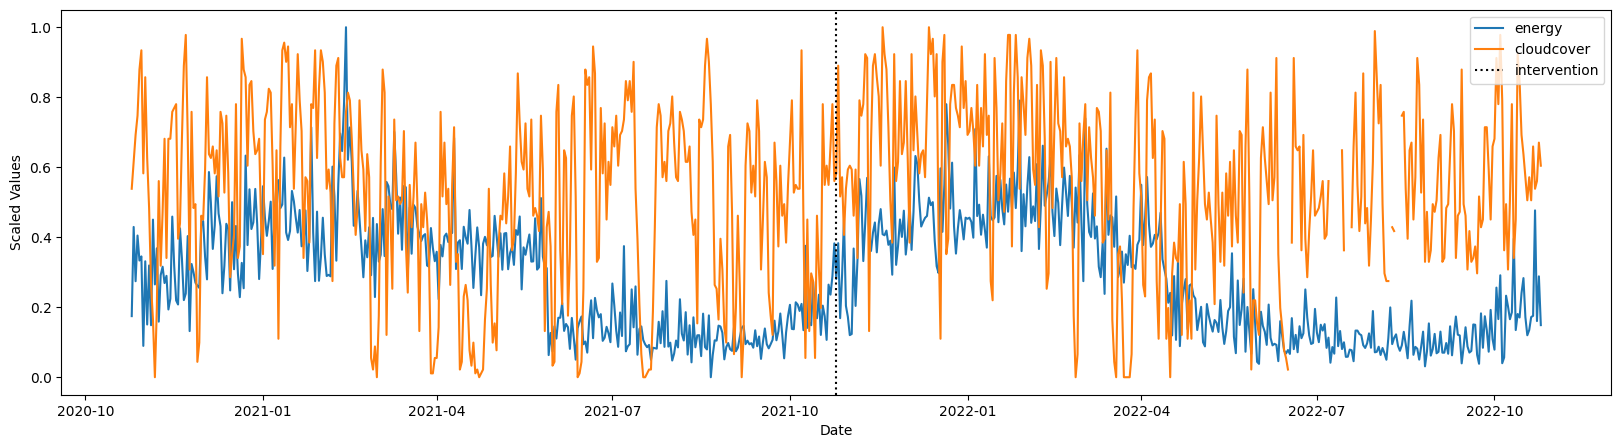

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
selected_columns = ['energy', 'cloudcover']
scaler = MinMaxScaler()
energy_data[selected_columns] = scaler.fit_transform(energy_data[selected_columns])
for column in selected_columns:
    ax.plot(energy_data['date'], energy_data[column], label=column)

# Add a vertical line at intervention
ax.axvline(energy_data['intervention'].iloc[0], c='k', ls=':', label='intervention')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Scaled Values')
ax.legend()

plt.show()

In [ ]:
# For each location_id, check null values for specified columns
columns = ['temp', 'tempmin', 'tempmax', 'cloudcover', 'humidity', 'preciptot', 'precip', 'windspeed']
missing_values_count = data.groupby('location_id')[columns].apply(lambda x: x.isnull().sum())
print(missing_values_count)

             temp  tempmin  tempmax  ...  preciptot  precip  windspeed
location_id                          ...                              
1420037         0        0        0  ...          0       0          0
1420043         0        0        0  ...          0       0          0
1420059         0        0        0  ...          0       0          0
1420066         0        0        0  ...          0       0          0
1420072         0        0        0  ...          0       0          0
...           ...      ...      ...  ...        ...     ...        ...
5651511         0        0        0  ...          0       0          0
6061367         0        0        0  ...          0       0          0
6377801         0        0        0  ...          0       0          0
6404010         0        0        0  ...          0       0          0
6454244       731      731      731  ...        731     731        731

[5042 rows x 8 columns]


In [ ]:
# Unique missing values for each location
for col in columns: print(f'Number of (unique) missing values for {col} column is', set(missing_values_count[col]))

Number of (unique) missing values for temp column is {0, 731}
Number of (unique) missing values for tempmin column is {0, 731}
Number of (unique) missing values for tempmax column is {0, 731}
Number of (unique) missing values for cloudcover column is {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 731}
Number of (unique) missing values for humidity column is {0, 731}
Number of (unique) missing values for preciptot column is {0, 731}
Number of (unique) missing values for precip column is {0, 731}
Number of (unique) missing values for windspeed column is {0, 731}


In [ ]:
# Get location_id for those with all missing values in weather covariates (except for cloudcover)
new_col = ['temp', 'tempmin', 'tempmax', 'humidity', 'preciptot', 'precip', 'windspeed']
location_id_to_drop = [location_id for location_id, row in missing_values_count[new_col].iterrows() if any(row != 0)]
# Drop specified location_id
data.drop(data.query(f'location_id=={location_id_to_drop}').index, inplace=True)
# Sort them by location_id and date
data = data.sort_values(['location_id', 'date']).reset_index(drop=True)

In [ ]:
# Get location_id for those with missing values in cloudcover column
location_id_to_replace = [location_id
                          for location_id, cloudcover in missing_values_count['cloudcover'].items()
                          if cloudcover!=0 and cloudcover!=731]
# Replace missing values in cloudcover column with the mean --> Why? Number of missing values within cloudcover is up to 12 (out of 731), ie <1%
for location_id in location_id_to_replace:
    data.loc[data['location_id'] == location_id, 'cloudcover'] = data.loc[data['location_id'] == location_id, 'cloudcover'].fillna(round(data.groupby('location_id')['cloudcover'].mean()[location_id], 1))

In [ ]:
# Check correlation among new columns (excluded location_id, date, intervention)
# Example for location_id 1420037
columns = data.columns[3:]
data.query(f'location_id=={1420037}')[columns].corr()

,energy,temp,tempmin,tempmax,cloudcover,humidity,preciptot,precip,windspeed
energy,1.000000,-0.032451,-0.005613,-0.066087,0.133971,0.085028,0.132806,0.131116,0.159144
temp,-0.032451,1.000000,0.963849,0.973973,-0.166236,-0.136482,-0.125328,-0.120339,-0.161856
tempmin,-0.005613,0.963849,1.000000,0.895783,-0.036770,0.009699,-0.072783,-0.069173,-0.107438
tempmax,-0.066087,0.973973,0.895783,1.000000,-0.283405,-0.248931,-0.172902,-0.167307,-0.218525
cloudcover,0.133971,-0.166236,-0.036770,-0.283405,1.000000,0.536153,0.245826,0.238536,0.188622
humidity,0.085028,-0.136482,0.009699,-0.248931,0.536153,1.000000,0.242414,0.234390,0.041707
preciptot,0.132806,-0.125328,-0.072783,-0.172902,0.245826,0.242414,1.000000,0.995220,0.295544
precip,0.131116,-0.120339,-0.069173,-0.167307,0.238536,0.234390,0.995220,1.000000,0.298445
windspeed,0.159144,-0.161856,-0.107438,-0.218525,0.188622,0.041707,0.295544,0.298445,1.000000


In [ ]:
# Drop correlated columns --> tempmin, tempmax and preciptot
data.drop(['tempmin', 'tempmax', 'preciptot'], axis=1, inplace=True)
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4
...,...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0
3679119,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4
3679120,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8
3679121,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2


#### Step 3 - Brightness algorithm

In [ ]:
# Load jersey brightness data
table_name_brightness = 'eliqdatalake.playground.jersey_brightness_data'
query_energy_brightness = f"SELECT * FROM {table_name_brightness}"
brightness = spark.sql(query_energy_brightness).toPandas().sort_values(['location_id']).reset_index(drop=True)

In [ ]:
df_brightness = data.merge(brightness, how='left', on=['location_id'])

In [ ]:
# Drop sealevelpressure, solarenergytot, solarenergy and solarradiation
df_brightness.drop(['intervention','energy', 'temp', 'tempmin', 'tempmax', 'cloudcover', 'humidity', 'preciptot', 'precip',	'windspeed'], axis=1, inplace=True)
df_brightness

,location_id,date,longitude,latitude,timezone
0,1420037,2020-09-20,-2.19,49.22,Europe/Jersey
1,1420037,2020-09-21,-2.19,49.22,Europe/Jersey
2,1420037,2020-09-22,-2.19,49.22,Europe/Jersey
3,1420037,2020-09-23,-2.19,49.22,Europe/Jersey
4,1420037,2020-09-24,-2.19,49.22,Europe/Jersey
...,...,...,...,...,...
3679118,6404010,2023-04-22,-2.22,49.19,Europe/Jersey
3679119,6404010,2023-04-23,-2.22,49.19,Europe/Jersey
3679120,6404010,2023-04-24,-2.22,49.19,Europe/Jersey
3679121,6404010,2023-04-25,-2.22,49.19,Europe/Jersey


In [ ]:
df_brightness_complete = brightness(df_brightness)
df_brightness_complete

,location_id,date,longitude,latitude,timezone,brightness,brightnessmax,brightness_s2s
0,1420037,2020-09-20,-2.19,49.22,Europe/Jersey,0.23,0.61,0.41
1,1420037,2020-09-21,-2.19,49.22,Europe/Jersey,0.23,0.61,0.41
2,1420037,2020-09-22,-2.19,49.22,Europe/Jersey,0.23,0.60,0.40
3,1420037,2020-09-23,-2.19,49.22,Europe/Jersey,0.22,0.60,0.40
4,1420037,2020-09-24,-2.19,49.22,Europe/Jersey,0.22,0.59,0.40
...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,-2.22,49.19,Europe/Jersey,0.30,0.75,0.52
3679119,6404010,2023-04-23,-2.22,49.19,Europe/Jersey,0.30,0.75,0.52
3679120,6404010,2023-04-24,-2.22,49.19,Europe/Jersey,0.31,0.75,0.53
3679121,6404010,2023-04-25,-2.22,49.19,Europe/Jersey,0.31,0.76,0.53


In [ ]:
# Convert pandas.DataFrame to PySpark DataFrame
df_brightness_complete_spark = spark.createDataFrame(df_brightness_complete)

In [ ]:
# Overview of df_brightness_complete_spark
df_brightness_complete_spark.show()
df_brightness_complete_spark.printSchema()

+-----------+-------------------+---------+--------+-------------+----------+-------------+--------------+
|location_id|               date|longitude|latitude|     timezone|brightness|brightnessmax|brightness_s2s|
+-----------+-------------------+---------+--------+-------------+----------+-------------+--------------+
|    1420037|2020-09-20 00:00:00|    -2.19|   49.22|Europe/Jersey|      0.23|         0.61|          0.41|
|    1420037|2020-09-21 00:00:00|    -2.19|   49.22|Europe/Jersey|      0.23|         0.61|          0.41|
|    1420037|2020-09-22 00:00:00|    -2.19|   49.22|Europe/Jersey|      0.23|          0.6|           0.4|
|    1420037|2020-09-23 00:00:00|    -2.19|   49.22|Europe/Jersey|      0.22|          0.6|           0.4|
|    1420037|2020-09-24 00:00:00|    -2.19|   49.22|Europe/Jersey|      0.22|         0.59|           0.4|
|    1420037|2020-09-25 00:00:00|    -2.19|   49.22|Europe/Jersey|      0.22|         0.59|          0.39|
|    1420037|2020-09-26 00:00:00|    

In [ ]:
# Save df_brightness_complete_spark as jersey_brightness_data_complete table in eliqdatalake.playground
df_brightness_complete_spark.write.saveAsTable("eliqdatalake.playground.jersey_brightness_data_complete", mode="overwrite")

In [ ]:
# Re-load jersey brightness data compplete
table_name_brightness_complete = 'eliqdatalake.playground.jersey_brightness_data_complete'
query_energy_brightness_complete = f"SELECT * FROM {table_name_brightness_complete}"
brightness = spark.sql(query_energy_brightness_complete).toPandas().sort_values(['location_id','date']).reset_index(drop=True)

In [ ]:
# Drop correlated columns --> brightness and brightnessmax
# Drop useless columns --> longitude, latitude and timezone
brightness.drop(['brightness', 'brightnessmax', 'longitude', 'latitude', 'timezone'], axis=1, inplace=True)

In [ ]:
# Join energy + weather + brightness
data = data.merge(brightness, how='left', on=['location_id', 'date'])
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40
...,...,...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52
3679119,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52
3679120,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53
3679121,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53


/root/.ipykernel/1116/command-415651027456758-574009896:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['energy_scaled'] = energy_scaled
/root/.ipykernel/1116/command-415651027456758-574009896:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['temp_scaled'] = temp_scaled


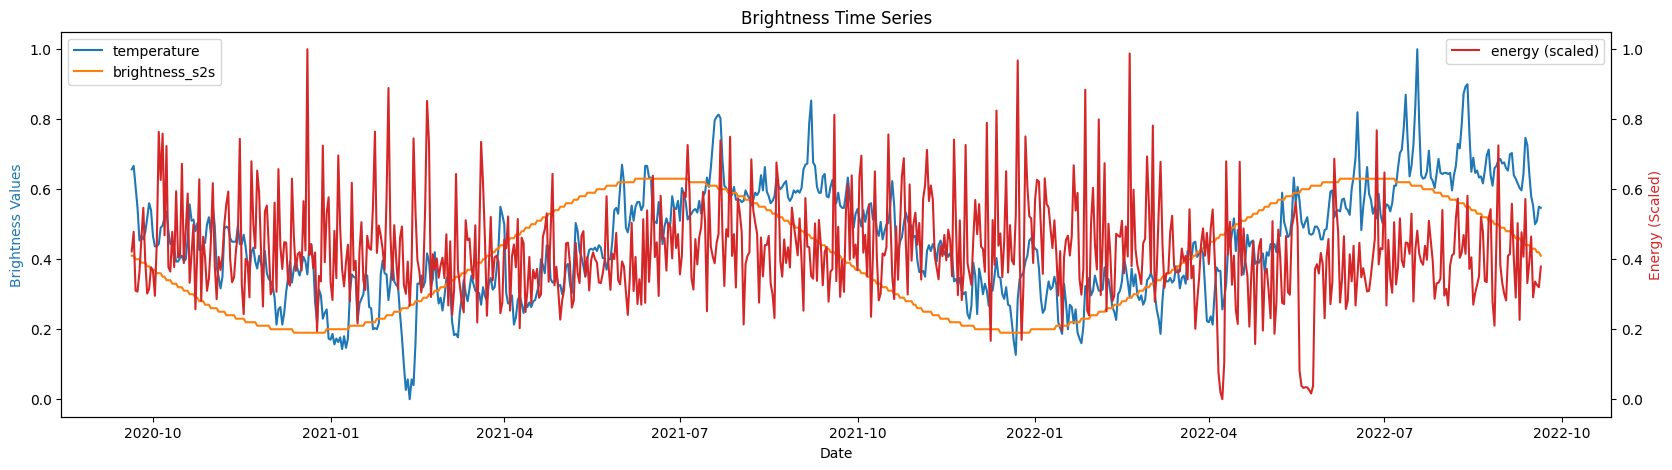

In [ ]:
# Example: location_id == 1420037
df_1 = data[data['location_id'] == 1420037]

# Assuming energy_data['energy'] contains the energy values
energy_values = df_1['energy'].values.reshape(-1, 1)
temp_values = df_1['temp'].values.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the energy values
energy_scaled = scaler.fit_transform(energy_values)
temp_scaled = scaler.fit_transform(temp_values)

# Assign the scaled values back to the DataFrame
df_1['energy_scaled'] = energy_scaled
df_1['temp_scaled'] = temp_scaled

# Plotting
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plot brightness time series
ax1.plot(df_1['date'], df_1['temp_scaled'], label='temperature')
ax1.plot(df_1['date'], df_1['brightness_s2s'], label='brightness_s2s')

# Set labels and title for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Brightness Values', color='tab:blue')
ax1.set_title('Brightness Time Series')
ax1.legend(loc='upper left')

# Create a second y-axis for the rescaled energy values
ax2 = ax1.twinx()
ax2.plot(df_1['date'], df_1['energy_scaled'], color='tab:red', label='energy (scaled)')

# Set labels and title for the second y-axis
ax2.set_ylabel('Energy (Scaled)', color='tab:red')
ax2.legend(loc='upper right')

plt.show()


#### Step 4 - Energy price cleaning

In [ ]:
# Load energy price data uk
table_name_energy_price = 'eliqdatalake.playground.energypricedatauk'
query_energy_price = f'SELECT * FROM {table_name_energy_price}'
energyprice = spark.sql(query_energy_price).toPandas().sort_values(['date']).reset_index(drop=True)

In [ ]:
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40
...,...,...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52
3679119,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52
3679120,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53
3679121,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53


In [ ]:
# Drop x column
energyprice.drop(['x'], axis=1, inplace=True)

In [ ]:
# Convert column date from datetime.date to pandas._libs.tslibs.timestamps.Timestamp
energyprice['date'] = energyprice['date'].apply(pd.Timestamp)

In [ ]:
# Join energy + weather + brightness + energy price
data = data.merge(energyprice, how='left', on=['date'])
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s,y,percentChange,change
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41,NaN,NaN,NaN
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41,NaN,NaN,NaN
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40,NaN,NaN,NaN
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40,43.71,1.580,0.68
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40,42.96,-1.716,-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52,NaN,NaN,NaN
3679119,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52,NaN,NaN,NaN
3679120,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53,97.84,-0.932,-0.92
3679121,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53,97.92,0.082,0.08


In [ ]:
# Apply price_cleaning to the DataFrame
data = price_cleaning(data, 'y', 'percentChange', 'change')

In [ ]:
# Check NaN values
data.isna().sum()

location_id               0
date                      0
intervention              0
energy                    0
temp                      0
cloudcover                0
humidity                  0
precip                    0
windspeed                 0
brightness_s2s            0
energyprice               0
energyprice_percChange    0
energyprice_change        0
dtype: int64

In [ ]:
# Rename columns: y --> energyprice, percentChange --> energyprice_percChange; change --> energyprice_change
data.rename(columns={'y':'energyprice', 'percentChange':'energyprice_percChange', 'change':'energyprice_change'}, inplace=True)
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s,energyprice,energyprice_percChange,energyprice_change
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41,43.71,0.000,0.00
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41,43.71,0.000,0.00
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40,43.71,0.000,0.00
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40,43.71,1.580,0.68
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40,42.96,-1.716,-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52,98.76,0.000,0.00
3679119,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52,98.76,0.000,0.00
3679120,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53,97.84,-0.932,-0.92
3679121,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53,97.92,0.082,0.08


In [ ]:
# Drop correlated columns --> energyprice_change
data.drop(['energyprice_change'], axis=1, inplace=True)

In [ ]:
# Convert pandas.DataFrame to PySpark DataFrame
#data_spark = spark.createDataFrame(data)

In [ ]:
# Overview of data_spark
#data_spark.show()
#data_spark.printSchema()

+-----------+-------------------+-------------------+-------+----+----------+--------+------+---------+--------------+-----------+----------------------+------------------+
|location_id|               date|       intervention| energy|temp|cloudcover|humidity|precip|windspeed|brightness_s2s|energyprice|energyprice_percChange|energyprice_change|
+-----------+-------------------+-------------------+-------+----+----------+--------+------+---------+--------------+-----------+----------------------+------------------+
|    1420037|2020-09-20 00:00:00|2021-09-20 00:00:00| 9429.0|18.6|      17.0|    86.0|   0.0|     12.2|          0.41|      43.71|                   0.0|               0.0|
|    1420037|2020-09-21 00:00:00|2021-09-20 00:00:00|10173.0|18.9|      11.0|    84.0|   0.0|     12.5|          0.41|      43.71|                   0.0|               0.0|
|    1420037|2020-09-22 00:00:00|2021-09-20 00:00:00| 7932.0|17.1|      42.0|    93.0|   0.0|     13.5|           0.4|      43.71|     

In [ ]:
# Save data_spark as jersey_data table in eliqdatalake.playground
#data_spark.write.saveAsTable("eliqdatalake.playground.jersey_data", mode="overwrite")

#### Step 5 - Checking stationarity (BSTS: not needed; ITS: needed)

**Augmented Dickey-Fuller (Unit Root) test**: Check stationarity and unit root (otherwise ts not forecastable).
* *Null hypothesis (H0)*: Non-stationarity of ts + ts contains a unit root
* *Alternative hypothesis (H1)*: Stationarity of ts

*Graphical analysis* (always wrong because based on sampe and not on true population): if mean reversion, then stationary
*Augmented Dickey-Fuller (Unit Root) test*: To make a statement on true population from the sample --> Hypothesis testing.\
Result: We reject the null hypothesis --> p-value is below the level of significance (1%, 5%, 10%)\
Conclusion: we state that the data generating process (not sample) of the ts is stationary (which implies also stationarity for the sample)

**Kwiatkowski-Phillips-Schmidt-Shin test**: It identifuies trend-staionarity in time series.
* *Null hypothesis (H0)*: Series is trend stationary or series has no unit root
* *Aternative hypothesis (H1)*: Series is non-stationary, or series has a unit root\

NB. The hypothesis is reversed in the KPSS test compared to ADF test\
c: data is stationary around a constant (default); ct: data is stationary around a trend

**Main focus**: Assess the stationarity of the time series data statistically\
**Approach**: Employ a brute-force sampling approach to calculate the mean, standard deviation, and median for a sample of each column using both ADF and KPSS tests\
**Result**:
* ADF = Do not reject the null hypothesis --> the series is non stationarity and it contains a unit root
* KPSS = Reject the null hypothesis --> the series is non stationary

**Analysis**: For ADF, both the mean and median of p-values exceed the level of significance. KPSS results indicate that mean and median p-values are below the level of significance (up to 10%).\
**Solution**: Differencing (lag=1, seems quite good)

In [ ]:
# Check stationarity for original columns with ADF and KPSS --> sample of 10 locations
columns = data.columns[3:]
sample = np.random.choice(data['location_id'].unique(), size=10, replace=False)
print('ADF\n')
for col in columns:
    p_values_adf = [adfuller(data.query(f'location_id=={loc}')[col])[1] for loc in sample]
    print(f'{col} mean:', mean(p_values_adf))
    print(f'{col} stdev:', stdev(p_values_adf))
    print(f'{col} median:', median(sorted(p_values_adf)))
    print()

print('KPSS\n')
for col in columns:
    p_values_kpss = [kpss(data.query(f'location_id=={loc}')[col])[1] for loc in sample]
    print(f'{col} mean:', mean(p_values_kpss))
    print(f'{col} stdev:', stdev(p_values_kpss))
    print(f'{col} median:', median(sorted(p_values_kpss)))
    print()

ADF

energy mean: 0.23017206852976557
energy stdev: 0.20212450491172673
energy median: 0.2274073369162928

temp mean: 0.09376091872974814
temp stdev: 0.09229813782546871
temp median: 0.07869131189937857

cloudcover mean: 2.4925102831971895e-07
cloudcover stdev: 5.306872156353038e-07
cloudcover median: 3.9003354827468116e-08

humidity mean: 6.529235147911094e-10
humidity stdev: 7.652155803849534e-10
humidity median: 2.3383363717168067e-10

precip mean: 2.987025131788199e-05
precip stdev: 5.143042385682711e-05
precip median: 1.0467093358587962e-05

windspeed mean: 2.3651998641460673e-09
windspeed stdev: 4.9631673029862435e-09
windspeed median: 3.1164866655204106e-18

brightness_s2s mean: 7.36618177656255e-15
brightness_s2s stdev: 1.7844673333290086e-14
brightness_s2s median: 9.860315738717827e-16

energyprice mean: 0.34355903815378835
energyprice stdev: 0.16613528127003366
energyprice median: 0.3428353859374157

energyprice_percChange mean: 1.5205097305869592e-17
energyprice_percChange s

In [ ]:
# Differencing: For each location_id (and column), we take the difference of consecutive terms in the series
# Substitute the first Nan with original value in new column
for col in columns:
    data[col + '_diff'] = data.groupby('location_id')[col].apply(lambda x: x.diff().fillna(x.iloc[0]))

In [ ]:
data

,location_id,date,intervention,energy,temp,cloudcover,humidity,precip,windspeed,brightness_s2s,energyprice,energyprice_percChange,energyprice_change,energy_diff,temp_diff,cloudcover_diff,humidity_diff,precip_diff,windspeed_diff,brightness_s2s_diff,energyprice_diff,energyprice_percChange_diff,energyprice_change_diff
0,1420037,2020-09-20,2021-09-20,9429.0,18.6,17.0,86.0,0.0,12.2,0.41,43.71,0.000,0.00,9429.0,18.6,17.0,86.0,0.0,12.2,0.41,43.71,0.000,0.00
1,1420037,2020-09-21,2021-09-20,10173.0,18.9,11.0,84.0,0.0,12.5,0.41,43.71,0.000,0.00,744.0,0.3,-6.0,-2.0,0.0,0.3,0.00,0.00,0.000,0.00
2,1420037,2020-09-22,2021-09-20,7932.0,17.1,42.0,93.0,0.0,13.5,0.40,43.71,0.000,0.00,-2241.0,-1.8,31.0,9.0,0.0,1.0,-0.01,0.00,0.000,0.00
3,1420037,2020-09-23,2021-09-20,7901.0,15.3,38.0,84.0,0.1,28.0,0.40,43.71,1.580,0.68,-31.0,-1.8,-4.0,-9.0,0.1,14.5,0.00,0.00,1.580,0.68
4,1420037,2020-09-24,2021-09-20,8638.0,12.5,36.0,77.0,0.2,40.4,0.40,42.96,-1.716,-0.75,737.0,-2.8,-2.0,-7.0,0.1,12.4,0.00,-0.75,-3.296,-1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679118,6404010,2023-04-22,2022-04-26,15038.0,10.3,52.0,86.0,0.0,18.0,0.52,98.76,0.000,0.00,7803.0,1.4,14.0,9.0,0.0,3.6,0.00,0.00,0.373,0.37
3679119,6404010,2023-04-23,2022-04-26,19145.0,10.1,69.0,92.0,0.0,23.4,0.52,98.76,0.000,0.00,4107.0,-0.2,17.0,6.0,0.0,5.4,0.00,0.00,0.000,0.00
3679120,6404010,2023-04-24,2022-04-26,8908.0,9.9,47.0,85.0,0.0,22.8,0.53,97.84,-0.932,-0.92,-10237.0,-0.2,-22.0,-7.0,0.0,-0.6,0.01,-0.92,-0.932,-0.92
3679121,6404010,2023-04-25,2022-04-26,9144.0,8.8,46.0,75.0,0.0,21.2,0.53,97.92,0.082,0.08,236.0,-1.1,-1.0,-10.0,0.0,-1.6,0.00,0.08,1.014,1.00


In [ ]:
# Re-check stationarity for new differentiated columns with ADF and KPSS --> sample of 10 locations
new_columns = data.columns[-7:]
sample = np.random.choice(data['location_id'].unique(), size=10, replace=False)
print('ADF\n')
for col in new_columns:
    p_values_adf = [adfuller(data.query(f'location_id=={loc}')[col])[1] for loc in sample]
    print(f'{col} mean:', mean(p_values_adf))
    print(f'{col} stdev:', stdev(p_values_adf))
    print(f'{col} median:', median(sorted(p_values_adf)))
    print()

print('KPSS\n')
for col in new_columns:
    p_values_kpss = [kpss(data.query(f'location_id=={loc}')[col])[1] for loc in sample]
    print(f'{col} mean:', mean(p_values_kpss))
    print(f'{col} stdev:', stdev(p_values_kpss))
    print(f'{col} median:', median(sorted(p_values_kpss)))
    print()

ADF

humidity_diff mean: 1.155357367575754e-16
humidity_diff stdev: 3.474630564110591e-16
humidity_diff median: 2.762557032654481e-21

precip_diff mean: 1.1110585433707963e-17
precip_diff stdev: 1.3666640077302529e-17
precip_diff median: 8.786494190969114e-18

windspeed_diff mean: 5.75482048526391e-18
windspeed_diff stdev: 2.840414729695211e-18
windspeed_diff median: 5.837548385396835e-18

brightness_s2s_diff mean: 0.7916904759726432
brightness_s2s_diff stdev: 0.05689636573789721
brightness_s2s_diff median: 0.7957439432624355

energyprice_diff mean: 1.1985978145786481e-07
energyprice_diff stdev: 2.4264440168527436e-07
energyprice_diff median: 6.315274427158648e-08

energyprice_percChange_diff mean: 1.428329701092317e-19
energyprice_percChange_diff stdev: 1.1288142756107e-19
energyprice_percChange_diff median: 1.4146898088137895e-19

energyprice_change_diff mean: 1.4285924123863529e-18
energyprice_change_diff stdev: 1.503812779000369e-18
energyprice_change_diff median: 1.172972139411206

In [ ]:
# Convert pandas.DataFrame to PySpark DataFrame
data_spark = spark.createDataFrame(data)

In [ ]:
# Overview of data_spark
data_spark.show()
data_spark.printSchema()

+-----------+-------------------+-------------------+-------+----+----------+--------+------+---------+--------------+-----------+----------------------+------------------+-----------+-------------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+---------------------------+-----------------------+
|location_id|               date|       intervention| energy|temp|cloudcover|humidity|precip|windspeed|brightness_s2s|energyprice|energyprice_percChange|energyprice_change|energy_diff|          temp_diff|cloudcover_diff|humidity_diff|         precip_diff|      windspeed_diff| brightness_s2s_diff|    energyprice_diff|energyprice_percChange_diff|energyprice_change_diff|
+-----------+-------------------+-------------------+-------+----+----------+--------+------+---------+--------------+-----------+----------------------+------------------+-----------+-------------------+---------------+-------------+--------------------+---

In [ ]:
# Save data_spark as jersey_data table in eliqdatalake.playground
data_spark.write.saveAsTable("eliqdatalake.playground.jersey_data", mode="overwrite")